# **Depencencies**
```bash
datasets==3.6.0
scipy==1.16.2
evaluate==0.4.6
tqdm==4.67.1
matplotlib==3.10.0
numpy==2.0.2
torch==2.8.0+cu126
transformers==4.57.1
```


In [ ]:
!pip install -q datasets==3.6.0 librosa jiwer torchaudio accelerate evaluate soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import datasets
datasets.disable_progress_bars()

from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import IPython.display as ipd
import time
import torch
import numpy as np
from transformers import GenerationConfig

import matplotlib.pyplot as plt
from tqdm import tqdm
from evaluate import load
from scipy.signal import spectrogram

from huggingface_hub import HfApi, HfFolder
from transformers import AutoModelForCTC, AutoProcessor

# **1 Data Preparation**

The dataset was taken from [HF](https://huggingface.co/datasets/ayush-shunyalabs/javanese-speech-dataset)

In [ ]:
# load dataset
dataset = load_dataset("ayush-shunyalabs/javanese-speech-dataset")

In [ ]:
print(len(dataset["train"]), len(dataset["test"]), len(dataset["validation"]))

3051 728 295


In [ ]:
print(dataset['train']['audio'][0])

{'path': '10006994087589965913.wav', 'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00287503,
       -0.00840455, -0.00089449]), 'sampling_rate': 16000}


In [ ]:
sample = dataset["train"][0]
display(
    ipd.Audio(data=sample['audio']['array'],
              rate=sample['audio']['sampling_rate'])
)
print('Transcript:')
print(sample["transcript"])

Transcript:
chiao lan sharipov nglapurake jarak sing aman saka panyurung sikap sing bener


In [ ]:
model_name = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [ ]:
# preprocess function
def preprocess(batch):
    # extract audio info
    speech_array = batch["audio"]["array"]
    sampling_rate = batch["audio"]["sampling_rate"]
    # process audio + text together
    inputs = processor(
        speech_array,
        sampling_rate=sampling_rate,
        text=batch["transcript"]
    )
    return inputs

In [ ]:
%%time

preprocessed_dataset = dataset.map(
    preprocess, remove_columns=dataset["train"].column_names
)

CPU times: user 1min 9s, sys: 8.49 s, total: 1min 18s
Wall time: 6min 17s


# **2 Model Finetuning**

In [ ]:
class DataCollatorSpeechSeq2SeqWithPadding:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, features):
        # isolate audio from labels
        input_features = [{"input_features": f["input_features"][0]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        # Pad both
        batch = self.processor.feature_extractor.pad(
            input_features, return_tensors="pt"
        )
        labels_batch = self.processor.tokenizer.pad(
            label_features,
            return_tensors="pt",
            padding=True
        )

        # Replace padding token id's of the labels by -100
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        batch["labels"] = labels
        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
batch = [preprocessed_dataset["train"][i] for i in range(4)]
collated = data_collator(batch)
print({k: v.shape for k, v in collated.items()})

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_features': torch.Size([4, 80, 3000]), 'labels': torch.Size([4, 44])}


In [ ]:
wer_metric = load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # decode both predictions and references
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True, token=TOKEN)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True, token=TOKEN)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-javanese",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    eval_strategy="no",
    save_strategy="epoch",
    num_train_epochs=3,
    learning_rate=1e-5,
    fp16=True,
    push_to_hub=False,
    report_to=[],
    logging_steps=50,
)

model.generation_config = GenerationConfig.from_model_config(model.config)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=preprocessed_dataset["train"],
    eval_dataset=preprocessed_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
    # tokenizer=processor.feature_extractor,
)

In [ ]:
start_time = time.time()
trainer.train()
end_time = time.time()
print(f'Time taken: {end_time-start_time:.2f}')

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Time taken: 2940.08


# **3 Evaluation**

In [ ]:
# switch to evaluation mode
model.eval()

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

In [ ]:
# preprocess test set for model evaluation
preprocessed_test = dataset["test"].map(
    preprocess, remove_columns=dataset["test"].column_names
)

In [ ]:
# move model to GPU if available
model.to("cuda" if torch.cuda.is_available() else "cpu")

# init empty lists for pred and true label
pred_strs = []
label_strs = []

# iterate through test set
for batch in tqdm(preprocessed_test, desc="Evaluating", total=len(preprocessed_test)):
    # prepare input features for model
    input_features = torch.tensor(batch["input_features"]).to(model.device)
    if input_features.ndim == 2:                   # (feature_dim, time)
     input_features = input_features.unsqueeze(0)  # add batch dim only once

    # generate predictions
    with torch.no_grad():
        predicted_ids = model.generate(input_features)
    # decode ids to texts
    pred_str = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    label_ids = np.array(batch["labels"])
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    # decode true label to text
    label_str = processor.batch_decode([label_ids], skip_special_tokens=True)[0]

    # store results for later
    pred_strs.append(pred_str)
    label_strs.append(label_str)

Evaluating:   0%|          | 0/728 [00:00<?, ?it/s]Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. If this is not desired, please set these values explicitly.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As

In [ ]:
# convert all to strings
pred_strs = [str(p) if not isinstance(p, str) else p for p in pred_strs]
label_strs = [str(l) if not isinstance(l, str) else l for l in label_strs]

# decode them
if isinstance(label_strs[0], (list, int)):
    label_strs = processor.batch_decode(label_strs, skip_special_tokens=True)
if isinstance(pred_strs[0], (list, int)):
    pred_strs = processor.batch_decode(pred_strs, skip_special_tokens=True)

In [ ]:
wer_metric = load("wer")
cer_metric = load("cer")

wer = wer_metric.compute(predictions=pred_strs, references=label_strs)
cer = cer_metric.compute(predictions=pred_strs, references=label_strs)
print(f"WER: {wer:.4f}, CER: {cer:.4f}")

WER: 0.2547, CER: 0.0791


In [ ]:
total_audio_duration = 0
total_inference_time = 0

for sample in tqdm(dataset["test"], desc="Measuring RTF"):
    audio = sample["audio"]
    duration = len(audio["array"]) / audio["sampling_rate"]
    total_audio_duration += duration

    # Measure inference time
    start = time.time()
    input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features
    pred = model.generate(torch.tensor(input_features).to(model.device))
    end = time.time()

    total_inference_time += (end - start)

rtf = total_inference_time / total_audio_duration
print(f"RTF: {rtf:.4f}")

Measuring RTF: 100%|██████████| 728/728 [11:51<00:00,  1.02it/s]

RTF: 0.0699


- RTF < 1 → faster than real-time (good for real-time apps)
- RTF > 1 → slower than real-time (fine for offline transcription)

In [ ]:
for i in range(5):
  print(f'\nRecord {i}:')
  display(ipd.Audio(dataset["test"][i]["audio"]["array"], rate=16000))
  print(f"Ref : {label_strs[i]}")
  print(f"Pred: {pred_strs[i]}")


Record 0:


Ref : dheweke duwe sikil kanthi sisik lan cakar dheweke ngendhog lan mlaku nganggo rong sikil mburi kaya t-rex
Pred: dheweke ndhewe sikil kanthi sisih lan sakhar dheweke ngendhok lan maku kanggo rong sikil mburi ngatirek

Record 1:


Ref : sekolah lapangan kuwi bageyan sing penting saka kelas biyasane guru bakal nggawa siswa-siswane menyang panggonan sing ora bisa diliwati bis
Pred: sekolah lapangan kuwi bageyan sing penting saka kelas biasane guru bakal nggawa siswasiswane menyang panggonan sing ora bisa diliwati bis

Record 2:


Ref : wit-witan gawe panganane saka srengenge kanthi fotosintesis wit-witan uga menehi eyup
Pred: mit-witan gawe panganane saka srengenge kanthi fotosyntesis mit-witan uga menei eop

Record 3:


Ref : sapa wae sing arep nyopir ana panggonan sing dhuwur utawa daerah gunung kudu nggatekke anane salju es utawa hawa sing anyep
Pred: sapa wae sing arep nyupir ana panggonan sing dhuwur utawa daerah gunung kudu nggatekake anane salju es utawa hawa sing anyap

Record 4:


Ref : panggunaan rekaman vidio wis ngasilake panemuan penting ing tapsiran ekspresi mikro obahing rai sing ana pirang-pirang milidetik
Pred: penggunaan rekaman video wis ngeselake panemuan penting ing tapsiran ekspresi mikro obaeng ray sing ana pirang-pirang mbili detik


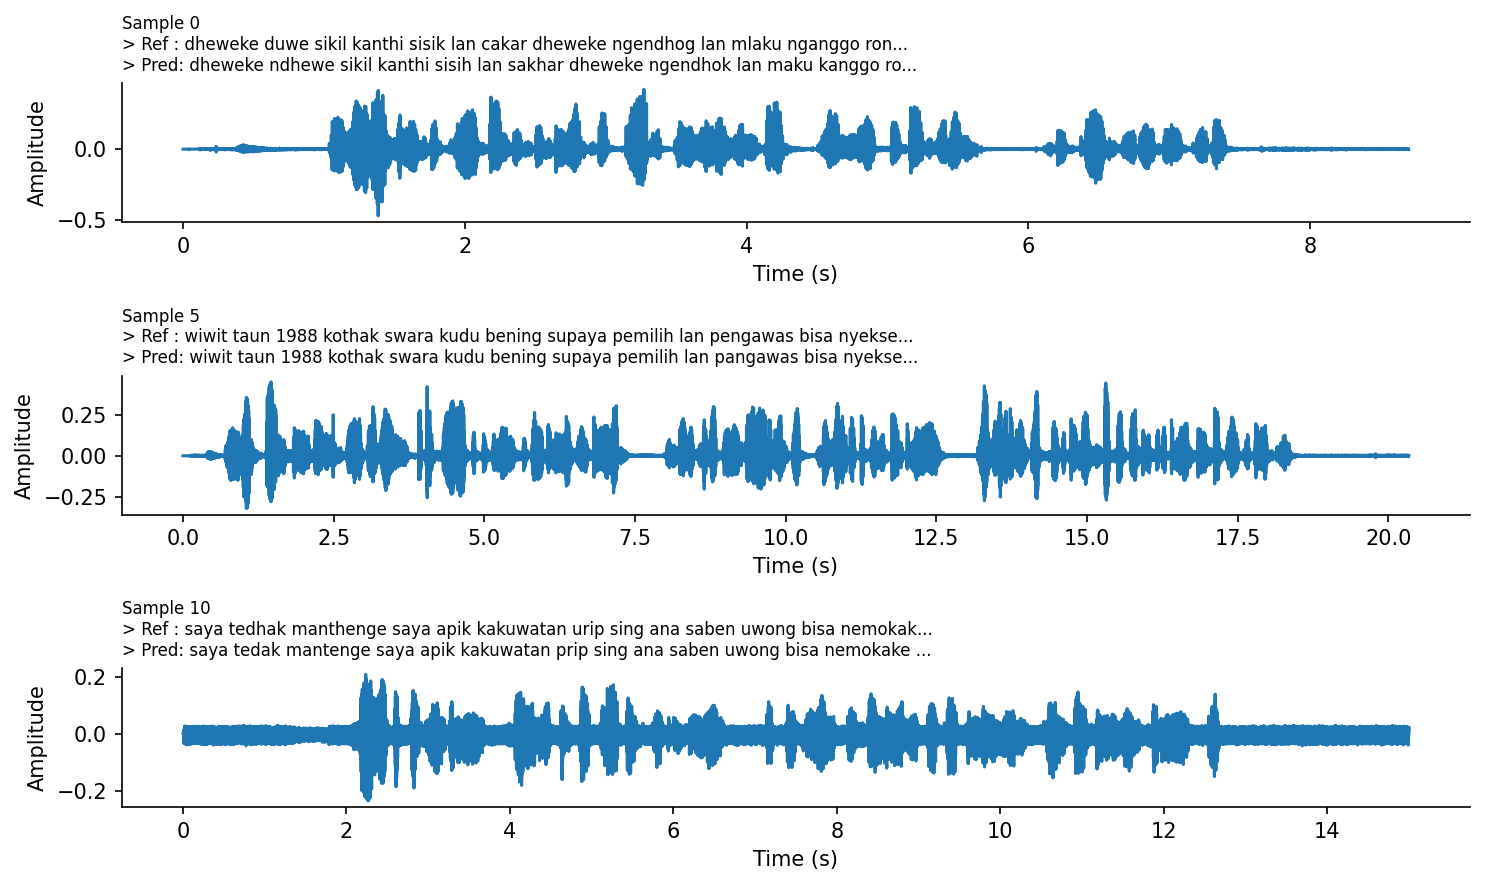

In [ ]:
def truncate_text(text, max_len=80):
    """Truncate text if too long."""
    return text if len(text) <= max_len else text[:max_len] + "..."

fig, axes = plt.subplots(3, 1, figsize=(10, 6), dpi=150, sharex=False)
for i, idx in enumerate([0, 5, 10]):
    audio = dataset["test"][idx]["audio"]
    waveform = np.array(audio["array"])
    sr = audio["sampling_rate"]

    # crop long texts
    ref_text = truncate_text(label_strs[idx])
    pred_text = truncate_text(pred_strs[idx])

    # plot waveform
    axes[i].plot(np.linspace(0, len(waveform)/sr, num=len(waveform)), waveform)
    axes[i].set_title(
        f"Sample {idx}\n"
        f"> Ref : {ref_text}\n"
        f"> Pred: {pred_text}",
        fontsize=8,
        loc="left")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Amplitude")
    axes[i].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

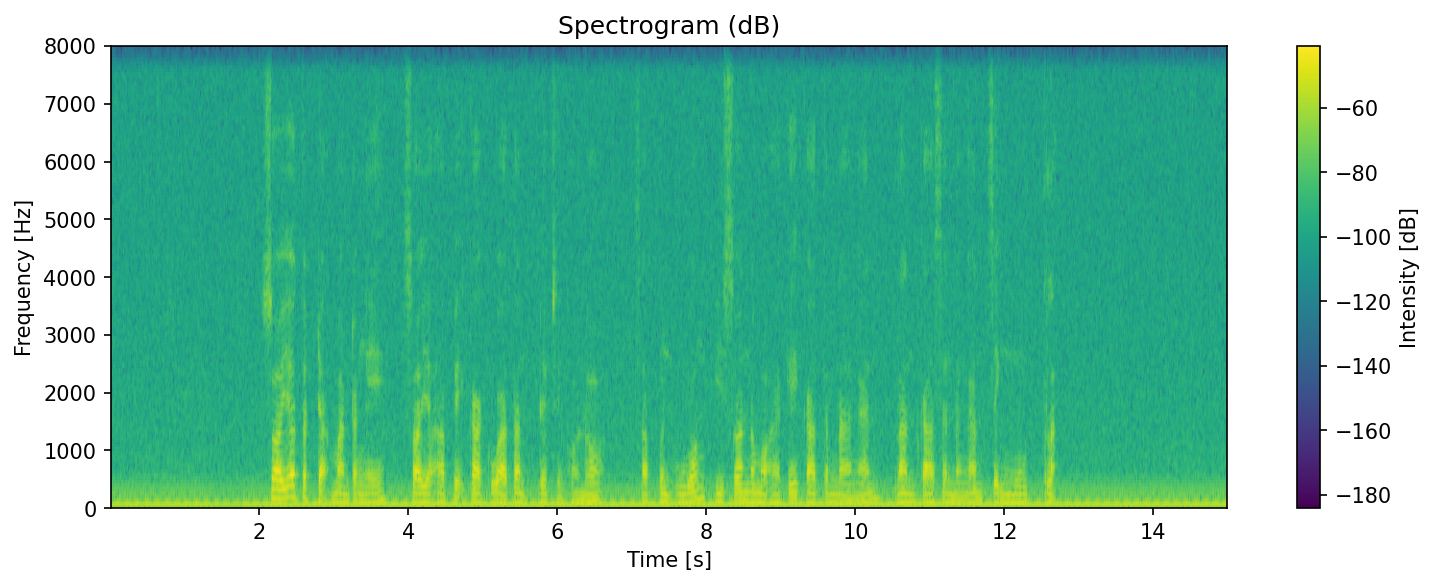

In [ ]:
f, t, Sxx = spectrogram(waveform, sr)
plt.figure(figsize=(12, 4), dpi=150)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading="gouraud")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram (dB)')
plt.colorbar(label='Intensity [dB]')
plt.show()

# **4 Model Upload to HuggingFace**

In [ ]:
# create HF repo
api = HfApi()
user = api.whoami()["name"]
repo_name = "javanese-asr"

# check if repo exists
if not api.repo_exists(f"{user}/{repo_name}"):
    api.create_repo(repo_name, private=True)
    print(f"Created new repo: {user}/{repo_name}")
else:
    print(f"Repo already exists: {user}/{repo_name}")

Repo already exists: eddiechen289/javanese-asr


In [ ]:
# check the repo
print(trainer.args.hub_model_id)
print(processor.tokenizer.name_or_path)

None
openai/whisper-small


In [ ]:
print("hub_model_id:", trainer.args.hub_model_id)
print("output_dir:", trainer.args.output_dir)

hub_model_id: eddiechen289/javanese-asr
output_dir: ./whisper-javanese


In [ ]:
trainer.save_model("javanese-asr")          # saves model + config
processor.save_pretrained("javanese-asr")   # saves processor files into same folder

# push model (weights + config + logs) and  processor (tokenizer + feature extractor)
api = HfApi()
api.upload_folder(
    folder_path="javanese-asr",
    repo_id="eddiechen289/javanese-asr",
    repo_type="model",
    token=api.token
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ese-asr/model.safetensors:   4%|4         | 41.8MB /  967MB            

  ...ese-asr/training_args.bin: 100%|##########| 6.03kB / 6.03kB            

CommitInfo(commit_url='https://huggingface.co/eddiechen289/javanese-asr/commit/1ee66e4ad5ffa6d5252648c7be097504197df3a2', commit_message='Upload folder using huggingface_hub', commit_description='', oid='1ee66e4ad5ffa6d5252648c7be097504197df3a2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/eddiechen289/javanese-asr', endpoint='https://huggingface.co', repo_type='model', repo_id='eddiechen289/javanese-asr'), pr_revision=None, pr_num=None)

# **Dependencies**

In [ ]:
!pip freeze

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.10.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.0
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.3.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.10.13.0.37.17
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.0.1
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.2
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.24.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.10.1
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.4
chex==0.1.90
cl